# LSTM Utilization Prediction

This Jupyter Notebook is aimed to test, if the utilization of hardware can be predicted by its historical utilization.
For this, a Long-Short Term Memory (LSTM) Neural Networks are used.

These are a special kind of Recurrent Neural Networks (RNN), which are capable of learning long-term dependencies.
This property fits our use case of trying to predict a future sequential time-series based on a past sequential time-series.


## Resources 

- This notebook relied on the sources:
  -  [How to apply LSTM using PyTorch](https://cnvrg.io/pytorch-lstm/) and
  -  [Predicting-cloud-CPU-usage-on-Azure-data](https://github.com/amcs1729/Predicting-cloud-CPU-usage-on-Azure-data).
- [Further Reading on LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

## Importing the Python Modules

*Note: If you encounter an error while trying to load the modules, go to the README.md for installing infos*

In [1]:
# used for statistical processes, i.e scaling the dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# plotting the data
import matplotlib.pyplot as plt
# used for the dataframes
import pandas as pd
# transforming dataframes into arrays
# and those arrays to Tensors, the ML approach can work with
import numpy as np
%matplotlib inline

# required for the LSTM model
import torch
import torch.nn as nn
from torch.autograd import Variable

## Loading the Dataframe

In this cell the dataframe with the machine utilization data will be loaded and prepared if necessary.

In [2]:
df = pd.read_csv('training_machine_sorted_df.csv')
df['timestamp'] = pd.to_datetime(df['start_date'])
df = df.set_index('timestamp')
# df = df.sort_index()
df.drop(columns=['start_date'], inplace=True)
df.head()

,machine,cpu_usage,gpu_wrk_util,avg_mem,max_mem,avg_gpu_wrk_mem,max_gpu_wrk_mem,gpu_type,runtime
timestamp,,,,,,,,,
1970-01-28 15:32:43+08:00,0018d759f400ef5c0457ab9c,35.636364,0.080000,2.060832,32.796875,2.447969,4.208984,V100,114.0
1970-01-29 16:01:19+08:00,0018d759f400ef5c0457ab9c,51.043478,13.692308,0.780721,1.835938,0.441632,0.993164,V100,104.0
1970-01-29 16:05:16+08:00,0018d759f400ef5c0457ab9c,59.483871,24.029412,3.403646,37.934570,2.487621,6.723633,V100,161.0
1970-01-30 11:54:59+08:00,0018d759f400ef5c0457ab9c,8021.102453,77.019231,4.084847,37.093750,6.160750,6.541992,V100,10397.0
1970-01-30 14:50:21+08:00,0018d759f400ef5c0457ab9c,81.285714,42.958333,4.360521,37.631836,3.374715,6.723633,V100,114.0


In [3]:
df.groupby('machine').count()

df = df.query("machine == 'ffb1bc4dc2fbb09d0477f0f0'")
df = df.drop(columns=['machine', 'gpu_type'])

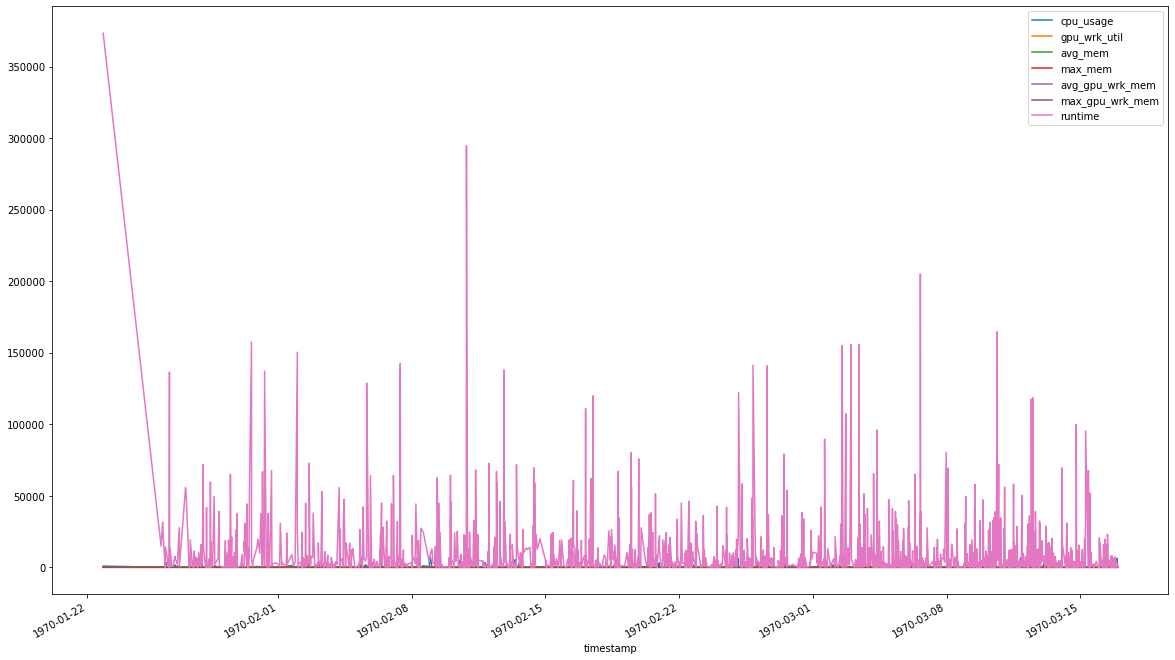

In [4]:
df.plot(figsize=(20, 12))
plt.show()

## Splitting the Dataframe into Train and Testset

In [5]:
TRAIN_LENGTH = round(len(df) * 0.8)
TEST_LENGTH = len(df) - TRAIN_LENGTH
train = df.iloc[0:TRAIN_LENGTH]
test = df[TRAIN_LENGTH:]

## Scaling the Datasets

In this step the train and test datasets are scaled to represent the data values in a (-1, 1) interval.
This is done to omit unwanted behaviour by the machine learning model. 

[Code Source](https://cnvrg.io/pytorch-lstm/)

In [6]:
mm_scaler = MinMaxScaler()
ss_scaler = StandardScaler()
X_ss = pd.DataFrame(ss_scaler.fit_transform(train))
y_mm = pd.DataFrame(mm_scaler.fit_transform(test))


## Split the Dataset

Now the dataset gets split into test and training dataset.

*Note: To later be able to convert the dataset into Tensors, it is necessary to convert them to numpy arrays via `.to_numpy()`*.

In [7]:
TRAIN_SPLIT: int = 450
TEST_SPLIT = TRAIN_SPLIT + 100

X_train = X_ss[:TRAIN_SPLIT].to_numpy()
X_test = X_ss[TRAIN_SPLIT:TEST_SPLIT].to_numpy()

y_train = y_mm[:TRAIN_SPLIT].to_numpy()
y_test = y_mm[TRAIN_SPLIT:TEST_SPLIT].to_numpy()

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (450, 7) (450, 7)
Testing Shape (100, 7) (100, 7)


## Converting the Datasets to Tensors

In order to be able to use the datasets with PyTorch, we first have to convert them to Tensors.

In [8]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

## Reshaping to Rows, Timestamps and Features

In the reshaping process, we add an additional dimension.

This is done, because LSTMs are built for sequential data and cannot "comprehend" simple 2-D data as its input.
They need to also have the timestamp information with them, so they can work properly.

In [9]:
# Reshaping
X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([450, 1, 7]) torch.Size([450, 7])
Testing Shape torch.Size([100, 1, 7]) torch.Size([100, 7])


## Create the LSTM Model



In [10]:
class LSTM(nn.Module):

    def __init__(self, num_classes: int, input_size: int, hidden_size: int, num_layers: int, seq_length: int) -> None:
        super(LSTM, self).__init__()
        self.num_classes: int = num_classes
        self.input_size: int = input_size
        self.hidden_size: int = hidden_size
        self.num_layers: int = num_layers
        self.seq_length: int = seq_length

        # long-short term memory layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True)

        # first fully connected layer
        self.fc_1 = nn.Linear(hidden_size, 128)
        # second fully connected layer
        self.fc_2 = nn.Linear(128, num_classes)
        # activation function
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden_state = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))
        internal_state = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(input, (hidden_state, internal_state))
        # Reshaping the data for the Dense layer
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc_2(out)
        
        return out
        


## Defining some hyperparameters

In the following cell, some hyperparameters are defined for further usage.

In [11]:
num_epochs: int = 2000
learning_rate: float = 0.005

# number of features
input_size: int = 7
# number of features in hidden state
hidden_size: int = 2
# number of stacked lstm layers
num_layers: int = 1
# number of output classes
num_classes: int = 7

## Instantiate the LSTM object

In [12]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1])

## Define the Loss Function and Optimizer

In [13]:
# mean squared error for regression
criterion = nn.MSELoss()
# optimizer function
optimizer = torch.optim.AdamW(lstm.parameters(), lr=learning_rate)

## Training Loop

In the following, the training of the LSTM model is done.

In [14]:
for epoch in range(num_epochs):
    # forward pass
    outputs = lstm.forward(X_train_tensors_final)
    # calculates the gradient and manually setting to 0
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)

    # calculates the loss of the loss function
    loss.backward()

    # improve from loss, i.e backpropagation
    optimizer.step()  
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


Epoch: 0, loss: 0.12661
Epoch: 100, loss: 0.02707
Epoch: 200, loss: 0.02632
Epoch: 300, loss: 0.02538
Epoch: 400, loss: 0.02464
Epoch: 500, loss: 0.02437
Epoch: 600, loss: 0.02420
Epoch: 700, loss: 0.02401
Epoch: 800, loss: 0.02385
Epoch: 900, loss: 0.02373
Epoch: 1000, loss: 0.02362
Epoch: 1100, loss: 0.02352
Epoch: 1200, loss: 0.02344
Epoch: 1300, loss: 0.02337
Epoch: 1400, loss: 0.02328
Epoch: 1500, loss: 0.02318
Epoch: 1600, loss: 0.02307
Epoch: 1700, loss: 0.02299
Epoch: 1800, loss: 0.02295
Epoch: 1900, loss: 0.02289


In [15]:
# old transformers
df_X_ss = ss_scaler.transform(df)
df_y_mm = mm_scaler.transform(df)

# converting to Tensors
df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))


In [16]:
# Evaluation Mode
lstm.eval()

# forward pass
train_predict = lstm(df_X_ss)
data_predict = train_predict.data.numpy()
dataY_plot = df_y_mm.data.numpy()

# reverse transformation
data_predict = mm_scaler.inverse_transform(data_predict)  
dataY_plot = mm_scaler.inverse_transform(dataY_plot)

In [17]:
data_predict_df = pd.DataFrame(data_predict, columns=df.columns)
data_y_plot_df = pd.DataFrame(dataY_plot, columns=df.columns)

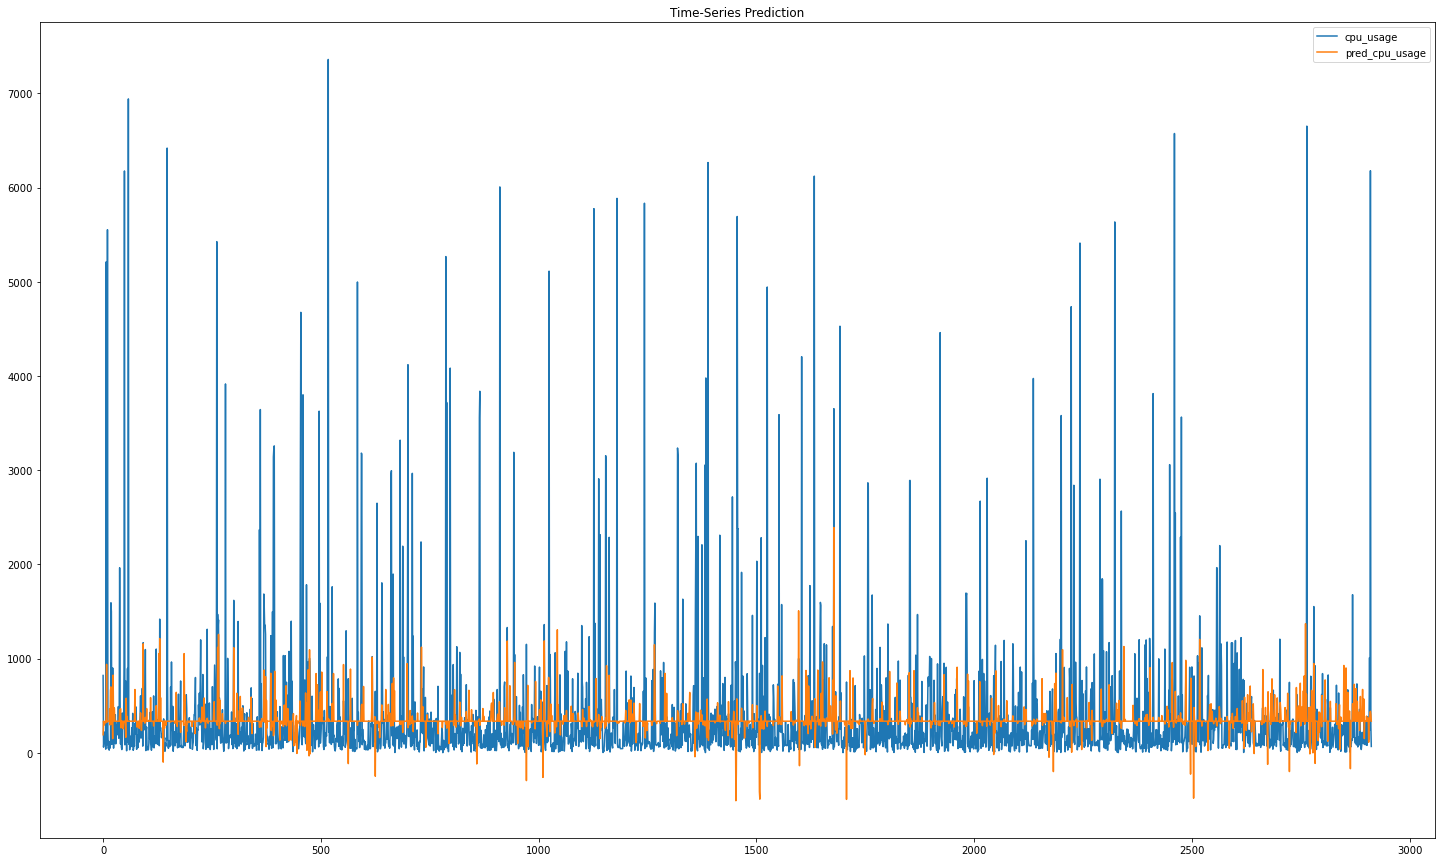

In [18]:
plt.figure(figsize=(25, 15))  # plotting
# plt.axvline(x=TRAIN_SPLIT, c='r', linestyle='--')  # size of the training set
pred_colums = ['pred_' + col for col in df.columns]

column = df.columns[0]

plt.plot(data_y_plot_df[column], label=column)  # actual plot
plt.plot(data_predict_df[column], label='pred_' + column)  # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()


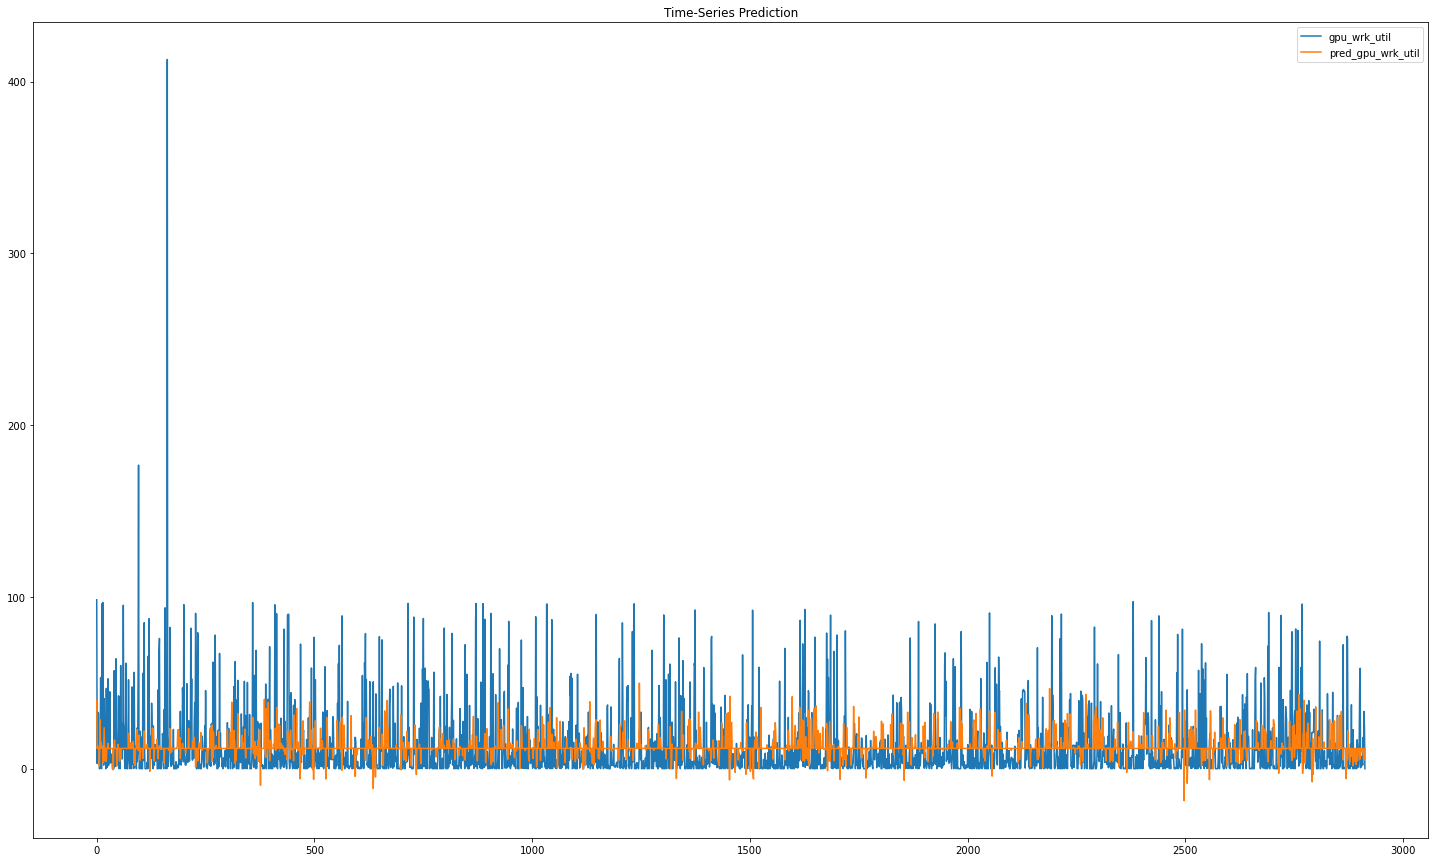

In [19]:
plt.figure(figsize=(25, 15))  # plotting
pred_colums = ['pred_' + col for col in df.columns]

column = df.columns[1]

plt.plot(data_y_plot_df[column], label=column)  # actual plot
plt.plot(data_predict_df[column], label='pred_' + column)  # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

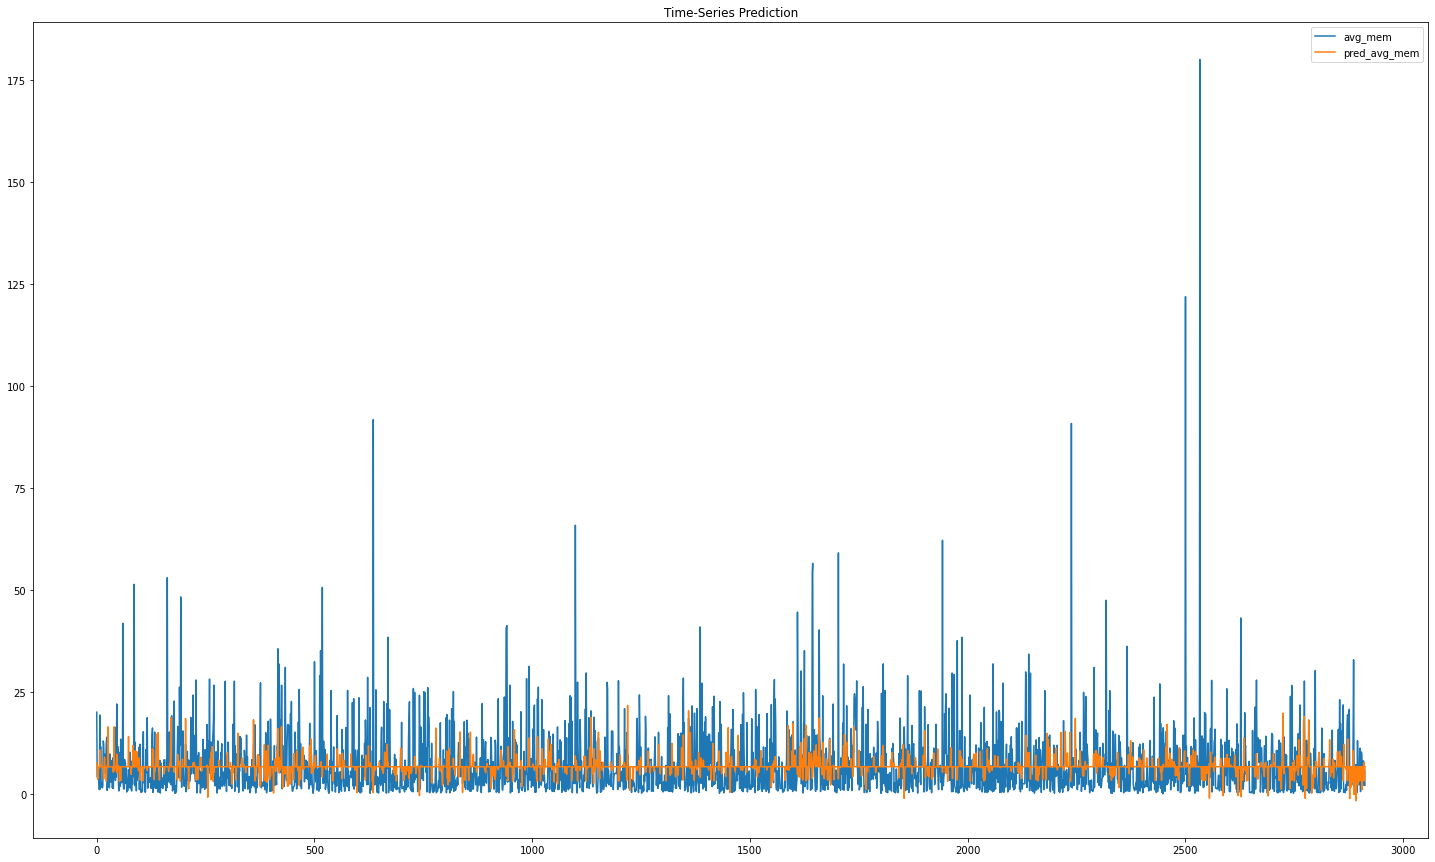

In [20]:
plt.figure(figsize=(25, 15))  # plotting
pred_colums = ['pred_' + col for col in df.columns]

column = df.columns[2]

plt.plot(data_y_plot_df[column], label=column)  # actual plot
plt.plot(data_predict_df[column], label='pred_' + column)  # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

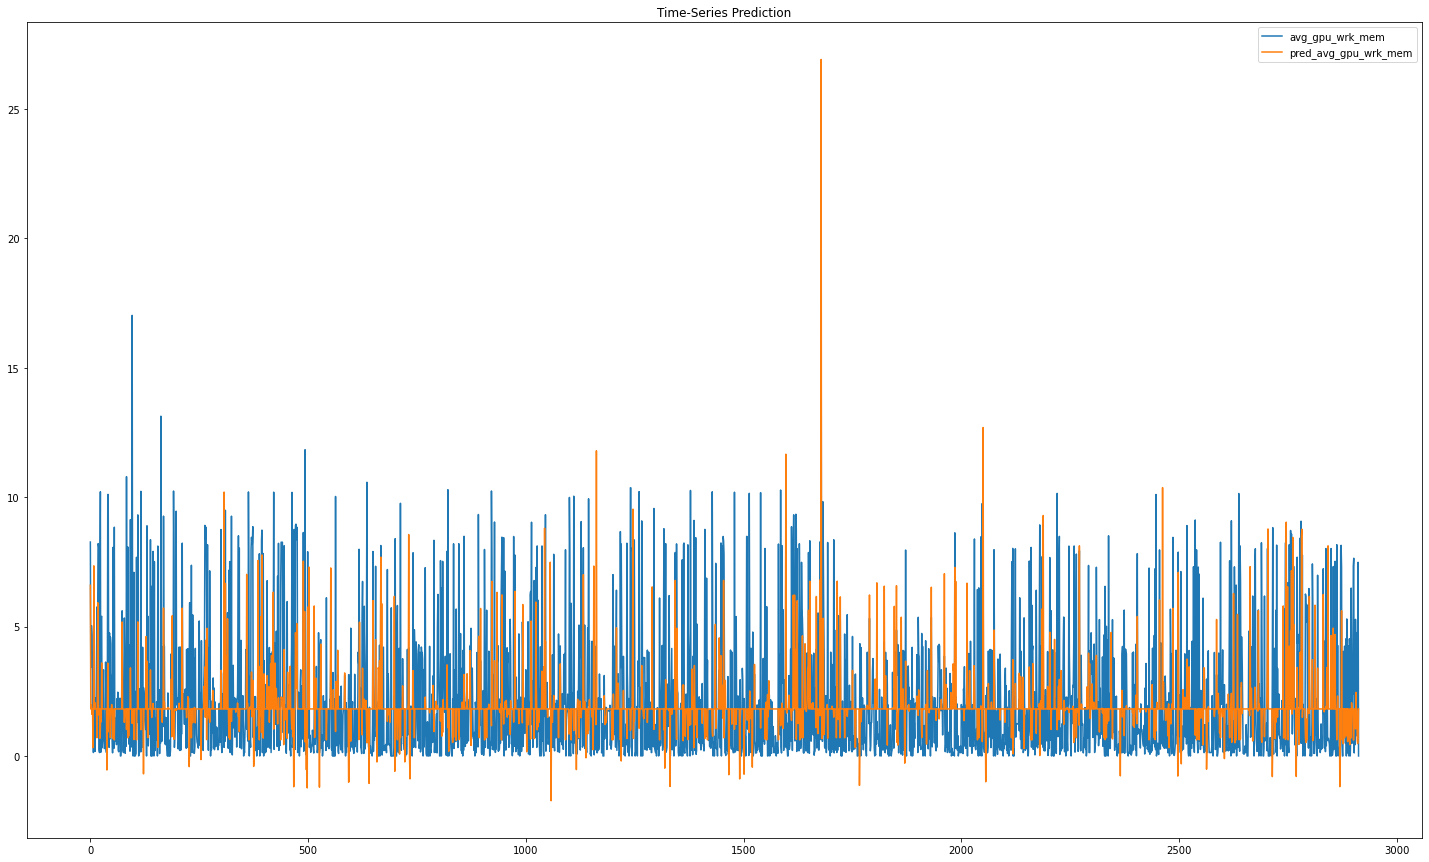

In [21]:
plt.figure(figsize=(25, 15))  # plotting
pred_colums = ['pred_' + col for col in df.columns]

column = df.columns[4]

plt.plot(data_y_plot_df[column], label=column)  # actual plot
plt.plot(data_predict_df[column], label='pred_' + column)  # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

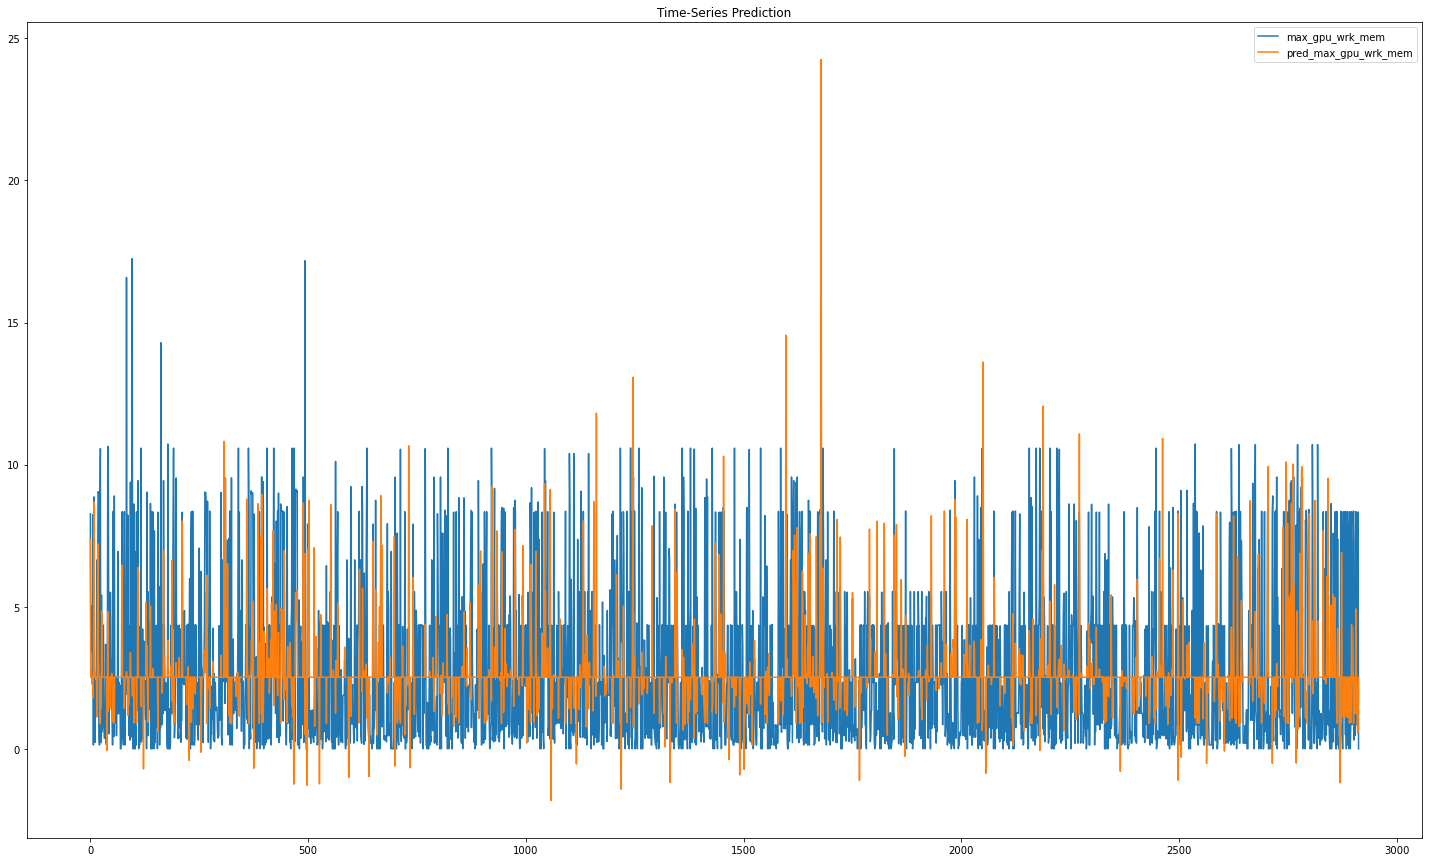

In [22]:
plt.figure(figsize=(25, 15))  # plotting
pred_colums = ['pred_' + col for col in df.columns]

column = df.columns[5]

plt.plot(data_y_plot_df[column], label=column)  # actual plot
plt.plot(data_predict_df[column], label='pred_' + column)  # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

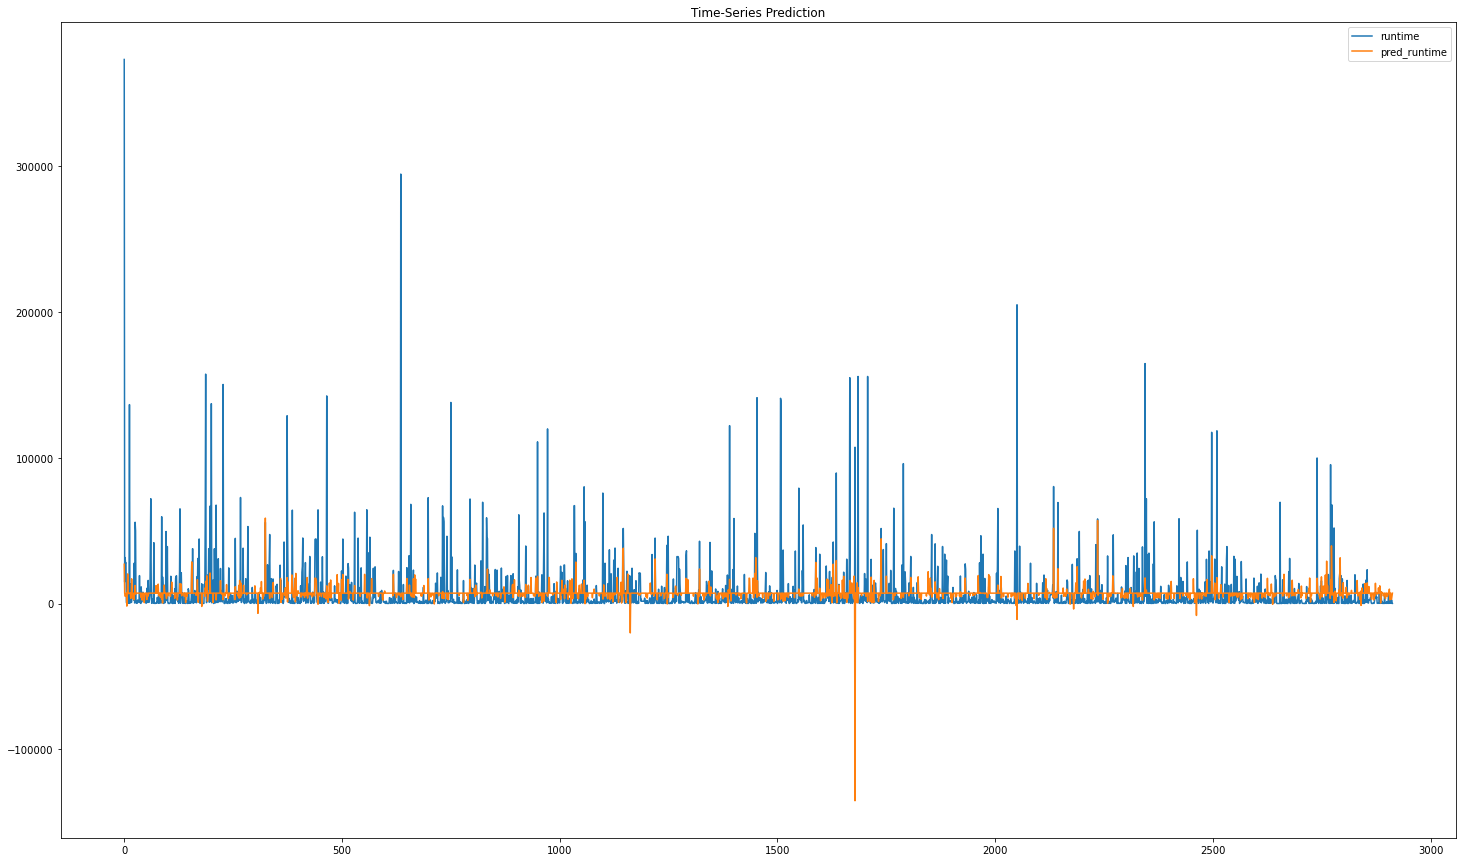

In [23]:
plt.figure(figsize=(25, 15))  # plotting
pred_colums = ['pred_' + col for col in df.columns]

column = df.columns[6]

plt.plot(data_y_plot_df[column], label=column)  # actual plot
plt.plot(data_predict_df[column], label='pred_' + column)  # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

### Root Mean Squared Error (RMSE)

$\operatorname{RMSD}(\hat{\theta}) = \sqrt{\operatorname{MSE}(\hat{\theta})} = \sqrt{\operatorname{E}((\hat{\theta}-\theta)^2)}$

In [24]:
# rmse_result = math.sqrt(mean_squared_error(y_test[:], preds[:]))
# print(f'Test Score: {rmse_result:.2f} RMSE')

### Mean Absolute Error (MAE)

$\mathrm {MAE} ={\frac {\sum _{i=1}^{n}\left|y_{i}-x_{i}\right|}{n}}={\frac {\sum _{i=1}^{n}\left|e_{i}\right|}{n}}
$

In [25]:
# mae_result = mean_absolute_error(y_test[:], preds[:])
# print(f'Test Score: {mae_result} MAE')

### Mean Absolute Percentage Error (MAPE)

$MAPE={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {A_{t}-F_{t}}{A_{t}}}\right|$

The **mean absolute percentage error (MAPE)**, is a measure of prediction accuracy of a forecasting (prediction) method in statistics.

$A_t$ is the actual value and $F_t$ is the predicted value. Their difference is divided by the actual value $A_t$. 

The absolute value in this ration is summed for every predicted point in time and divided by the number of fitted points $n$.

In [26]:
# mape_result = np.mean(np.abs(y_test - preds)/np.abs(y_test)*100)
# print(f'Test Score: {mape_result} MAPE')